In [1]:
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import pandas as pd

In [2]:
mitsuba = pd.read_pickle("data/mitsuba-box-25-12-7.pkl")
raven = pd.read_pickle("data/raven-box-25-12-7.pkl")

absorpt = [0.1, 0.5, 0.9]
s = 1.0

In [3]:
def db(x):
    energy = x * 0.
    # Compute the whole integral
    total = np.trapz(x, axis=0)
    for i in range(x.shape[0]):
        energy.iloc[i] = (np.trapz(x[i:], axis=0) / total)

    # in dB
    energy_db = 10 * np.log10(energy)
    
    return energy_db

def plot_comparison(absorpt, s):
    from utils import db_pd
    t1 = np.linspace(0, 4, mitsuba.shape[0])
    t2 = np.linspace(0, 4.1, raven.shape[0])

    plt.figure(figsize=(10, 5))
    for a in absorpt:
        plt.plot(t1, db_pd(mitsuba[f'a{a:.1f}-s{s:.1f}']), label=f'mitsba-{a}')
        plt.plot(t2, db_pd(raven[f'a{a:.1f}-s{s:.1f}']), label=f'raven-{a}')

    #plt.ylim(-100, 10)
    plt.ylabel("Energy [dB]")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.savefig("compare-absorption.png")
    plt.title(f"Scattering: {s:.1f}")
    
from acoustics import EDC, T, EDT, C, D50
def compute_acoustic_parameters(rir, fs):
    edc = EDC(rir, energy=True)
    t20 = T(20, edc) / fs
    t30 = T(30, edc) / fs
    edt = EDT(edc) / fs
    c50 = C(50, rir, fs, energy=True)
    c80 = C(80, rir, fs, energy=True)
    d50 = D50(rir, fs, energy=True)
    
    result = {
        #"EDC": edc,
        "T20": t20, 
        "T30": t30,
        "EDT": edt, 
        "C50": c50, 
        "C80": c80, 
        "D50": d50}
    return result
  
def compare_acoustic_params(a, s):
    mit = compute_acoustic_parameters(mitsuba[f'a{a:.1f}-s{s:.1f}'], 100)
    rav = compute_acoustic_parameters(raven[f'a{a:.1f}-s{s:.1f}'], 100)
    df = pd.concat([
        pd.DataFrame.from_dict(mit, 'index', columns=['mitsuba']),
        pd.DataFrame.from_dict(rav, 'index', columns=['raven'])
    ], axis=1).T
    df.loc["%dev"] = ((df.loc['mitsuba'] - df.loc['raven']) / df.loc['mitsuba']) * 100
    
    return df

/home/leonard/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leonard/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leonard/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,T20,T30,EDT,C50,C80,D50
mitsuba,2.933131,2.933223,2.927822,-11.359754,-6.640497,0.068136
raven,2.941232,2.943904,3.064543,-15.086894,-10.006770,0.030064
%dev,-0.276188,-0.364119,-4.669744,-32.810044,-50.693078,55.875850


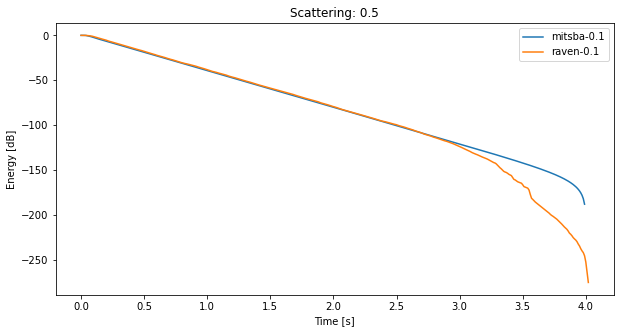

In [56]:
plot_comparison([0.1], 0.5)
#plt.ylim(-100, 5)
#plt.xlim(0, 1.0)
compare_acoustic_params(0.1, 0.5)

In [46]:
def EDT(edc, **kwargs):
    """
    Die frühe Abklingzeit (en: early decay time (EDT)) muss (wie die herkömmliche Abklingzeit) aus der Neigung der
    integrierten Impulsantwort-Kurven ermittelt werden. Die Neigung der Abklingkurve sollte aus linearen
    Regressions-Geraden bester Anpassung aus den anfänglichen 10 dB (zwischen 0 dB und –10 dB) des
    Abklingvorgangs ermittelt werden. Die Abklingzeiten sollten aus der Steigung innerhalb der Zeit, die für einen
    60 dB–Abklingvorgang erforderlich ist, ermittelt werden
    """
    return T(10, edc, start=0, **kwargs)

def T(n, edc, start=-5, poly=False, plot=False, plot_fit_lines=False):
    """
    Zeit, die erforderlich ist, damit die räumlich gemittelte Schallenergiedichte in
    einem geschlossenen Raum um 60 dB sinkt, nachdem die Schallquelle abgeschaltet wurde.
    
    T kann basierend auf einem kürzeren Dynamikbereich als 60 dB ermittelt und auf eine Abklingzeit von
    60 dB extrapoliert werden. Sie wird dann entsprechend gekennzeichnet. So wird sie, wenn T aus der Zeit ermittelt wird, zu
    der die Abklingkurve erstmalig die Werte 5 dB und 25 dB unter dem Anfangspegel erreicht, mit T 20 , gekennzeichnet.
    Werden Abklingwerte von 5 dB bis 35 dB unter dem Anfangspegel verwendet, werden sie mit T 30 gekennzeichnet.
    
    n: in T_n
    x: Signal
    """
    rt60_from = np.argmax(edc < start)
    rt60_to = np.argmax(edc < -n+start)
    xp = np.linspace(rt60_from, rt60_to, rt60_to - rt60_from + 1)
    
    # Abklingrate bestimmen
    z = np.polyfit(xp, edc[rt60_from:rt60_to + 1], 1)
    
    if plot:
        if plot_fit_lines:
            plt.axvline(x = rt60_from)
            plt.axvline(x = rt60_to)
            plt.axhline(y = -n+start)
            plt.axhline(y = start)
        plt.plot(xp, np.poly1d(z)(xp))
    
    if poly:
        return -60 / z[0], np.poly1d(z)
    else:
        return -60 / z[0]

/home/leonard/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leonard/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/leonard/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-15.0, 5.0)

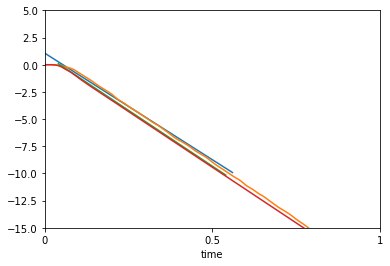

In [55]:
EDT(EDC(raven[f'a{0.1:.1f}-s{0.5:.1f}'], energy=True), plot=True)
db(raven[f'a{0.1:.1f}-s{0.5:.1f}']).plot()
EDT(EDC(mitsuba[f'a{0.1:.1f}-s{0.5:.1f}'], energy=True), plot=True)
db(mitsuba[f'a{0.1:.1f}-s{0.5:.1f}']).plot()
plt.xlim(0, 100)
plt.ylim(-15, 5)